In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import os
import sys
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
sys.path.append('..')

from cifar100cnn.data import get_cifar_data
from cifar100cnn.extractor import *
from cifar100cnn.load_models import MODEL_PATHS, load_model

In [4]:
train_loader, val_loader, test_loader, class_names = get_cifar_data(num_classes=100, augment=True)
class_dict = {idx: name for idx, name in enumerate(class_names)}

class_dict

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Saved class names to class_names.txt


{0: 'apple',
 1: 'aquarium_fish',
 2: 'baby',
 3: 'bear',
 4: 'beaver',
 5: 'bed',
 6: 'bee',
 7: 'beetle',
 8: 'bicycle',
 9: 'bottle',
 10: 'bowl',
 11: 'boy',
 12: 'bridge',
 13: 'bus',
 14: 'butterfly',
 15: 'camel',
 16: 'can',
 17: 'castle',
 18: 'caterpillar',
 19: 'cattle',
 20: 'chair',
 21: 'chimpanzee',
 22: 'clock',
 23: 'cloud',
 24: 'cockroach',
 25: 'couch',
 26: 'crab',
 27: 'crocodile',
 28: 'cup',
 29: 'dinosaur',
 30: 'dolphin',
 31: 'elephant',
 32: 'flatfish',
 33: 'forest',
 34: 'fox',
 35: 'girl',
 36: 'hamster',
 37: 'house',
 38: 'kangaroo',
 39: 'keyboard',
 40: 'lamp',
 41: 'lawn_mower',
 42: 'leopard',
 43: 'lion',
 44: 'lizard',
 45: 'lobster',
 46: 'man',
 47: 'maple_tree',
 48: 'motorcycle',
 49: 'mountain',
 50: 'mouse',
 51: 'mushroom',
 52: 'oak_tree',
 53: 'orange',
 54: 'orchid',
 55: 'otter',
 56: 'palm_tree',
 57: 'pear',
 58: 'pickup_truck',
 59: 'pine_tree',
 60: 'plain',
 61: 'plate',
 62: 'poppy',
 63: 'porcupine',
 64: 'possum',
 65: 'rabbit',

In [5]:
classes_A = np.arange(50)
classes_B = np.arange(50, 100)

models = {name: load_model(name, "../" + path, device) for name, path in MODEL_PATHS.items()}
feature_extractor = FeatureExtractor(device)

..\cifar100cnn\load_models.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


In [6]:
def calculate_accuracy(model, representative, test_loader, class_type, test_features_path, test_labels_path, k, metric='cosine'):
    test_features = np.load(test_features_path)
    test_labels = np.load(test_labels_path)

    mask_test = np.isin(test_labels, class_type)
    test_features, test_labels_A = test_features[mask_test], test_labels[mask_test]

    # POPRAWKA: Zastosuj normalizację L2 dla metryki euklidesowej, jeśli norm='l2'
    if metric == 'euclidean':
        normalizer = Normalizer(norm='l2')
        train_features = np.vstack(list(representative.values()))
        train_features = normalizer.fit_transform(train_features)
        test_features = normalizer.transform(test_features.copy())
    else:
        train_features = np.vstack(list(representative.values()))

    predictions = classify_knn(test_features, representative, k, metric)
    accuracy = evaluate_accuracy(predictions, test_labels_A)

    return accuracy

In [7]:
def plot_stage(ax, features_pca, classes, accuracy, stage_name, num_samples):
    scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], c=classes, cmap='tab20', s=100, alpha=0.8)
    ax.set_title(f"{stage_name} ({num_samples} samples/class)\nAccuracy: {accuracy:.2f}%")
    ax.set_xticks([])
    ax.set_yticks([])

    for i, txt in enumerate(classes):
        ax.text(features_pca[i, 0], features_pca[i, 1], class_dict[txt], fontsize=9)

In [8]:
# creates plots for stage A and B (above and below)

def plot_stages(pca_results_A, pca_results_B, classes_list_A, classes_list_B, 
                            accuracies_A, accuracies_B, model_name, class_dict):
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    sample_counts = [1, 5, 10]

    # A:
    for col, num_samples in enumerate(sample_counts):
        idx = sample_counts.index(num_samples)
        plot_stage(axs[0, col], pca_results_A[idx], classes_list_A[idx], accuracies_A[idx], "Stage A", num_samples)

    # B:
    for col, num_samples in enumerate(sample_counts):
        idx = sample_counts.index(num_samples)
        plot_stage(axs[1, col], pca_results_B[idx], classes_list_B[idx], accuracies_B[idx], "Stage B", num_samples)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f"Model: {model_name}", fontsize=16)
    plt.show()

In [9]:
base_dir_A = os.path.join("..", "cache/stage2")
base_dir_B = os.path.join("..", "cache/stage3")

models_names = ["resnet18_scratch", "resnet18_fine_tuned", "resnet50_scratch", "resnet50_fine_tuned", "wide_resnet"]
nums_samples = [1, 5, 10]

resnet18_scratch: 1 44.7
resnet18_scratch: 5 55.48
resnet18_scratch: 10 57.4


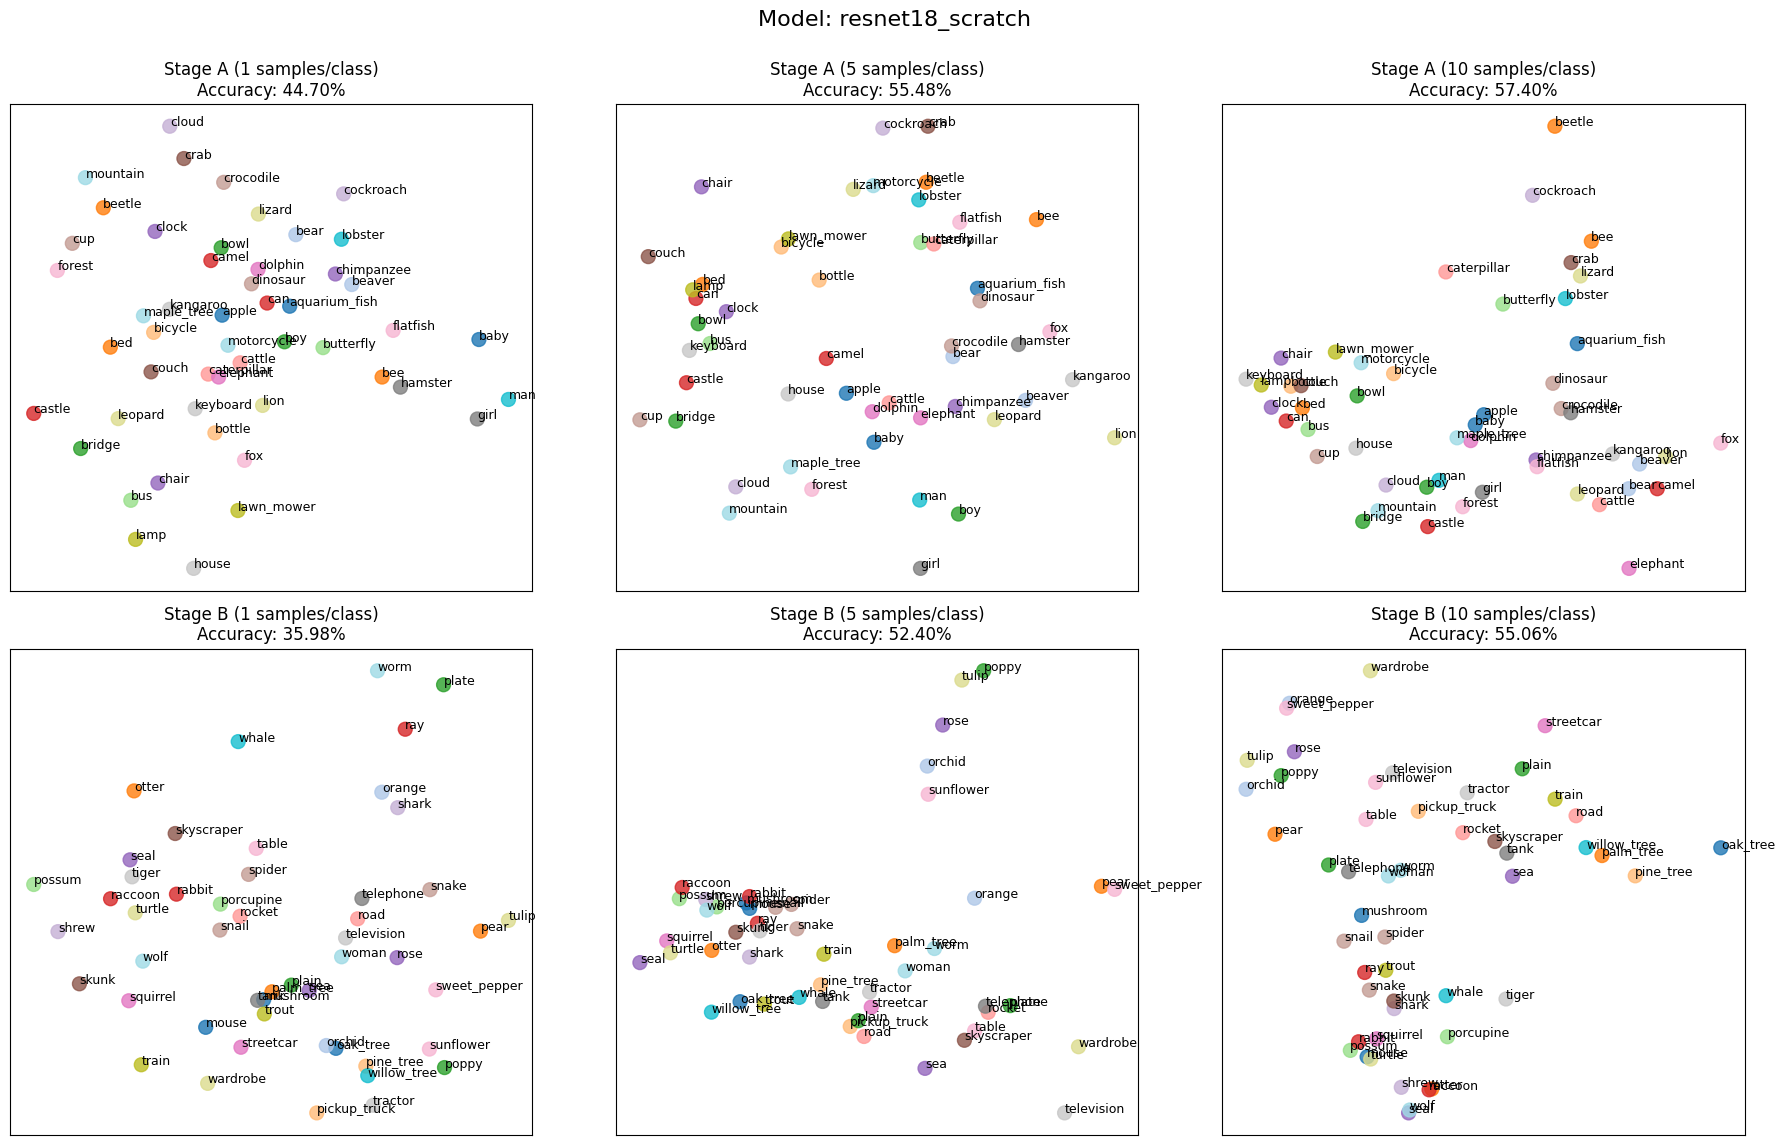

resnet18_fine_tuned: 1 40.96
resnet18_fine_tuned: 5 49.86
resnet18_fine_tuned: 10 52.400000000000006


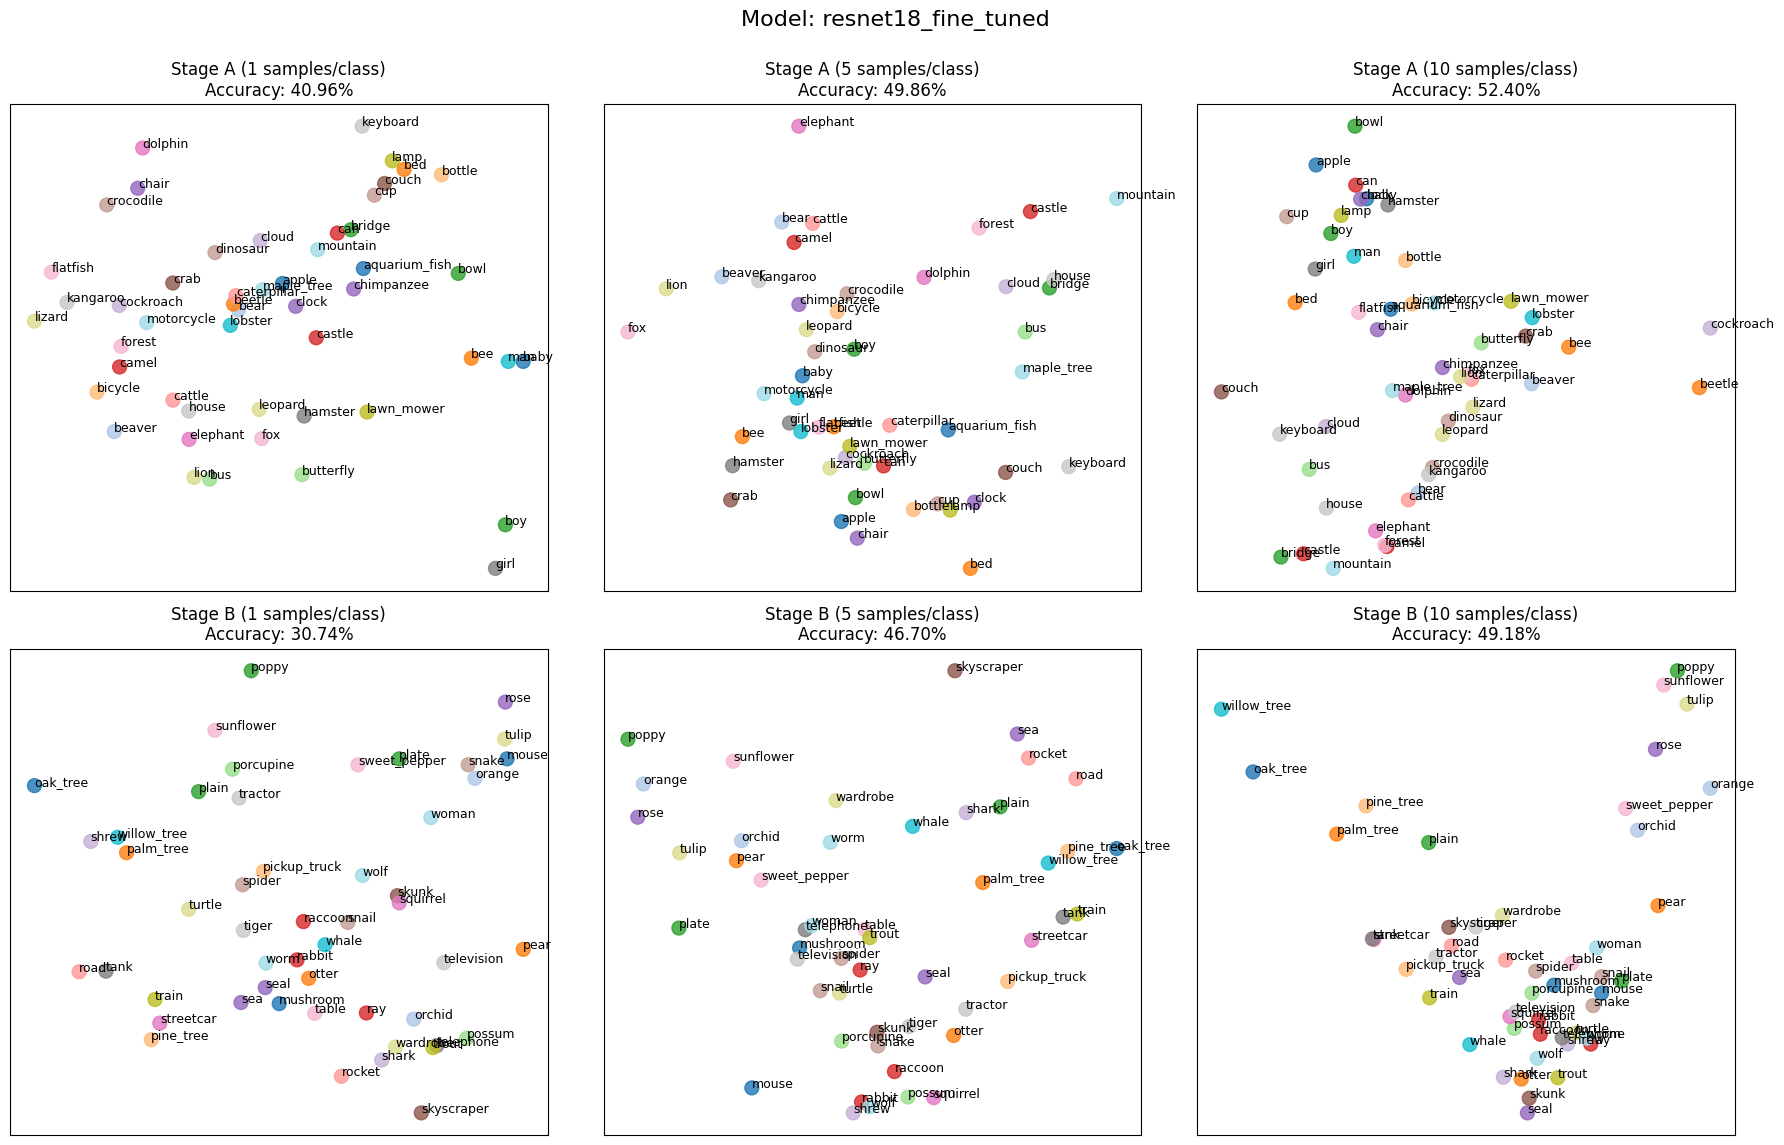

resnet50_scratch: 1 45.58
resnet50_scratch: 5 53.7
resnet50_scratch: 10 55.64


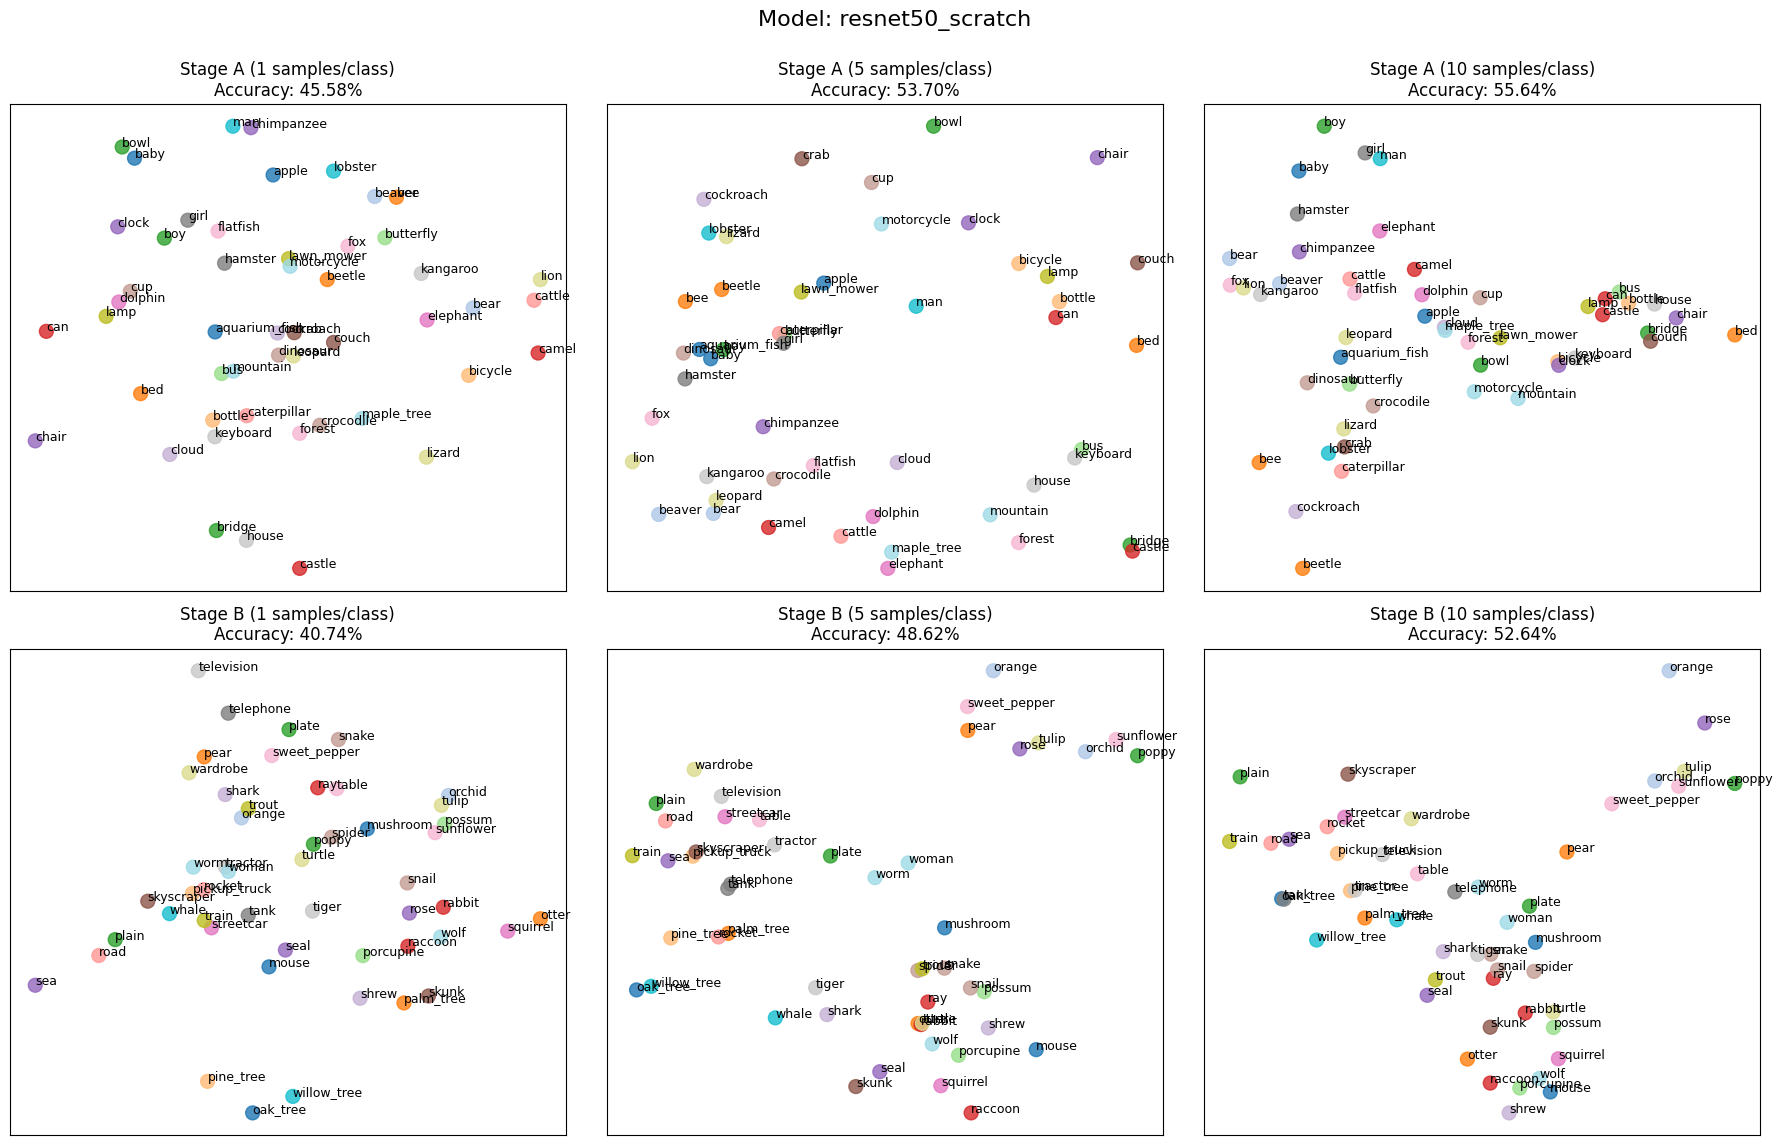

resnet50_fine_tuned: 1 47.0
resnet50_fine_tuned: 5 51.42
resnet50_fine_tuned: 10 53.18000000000001


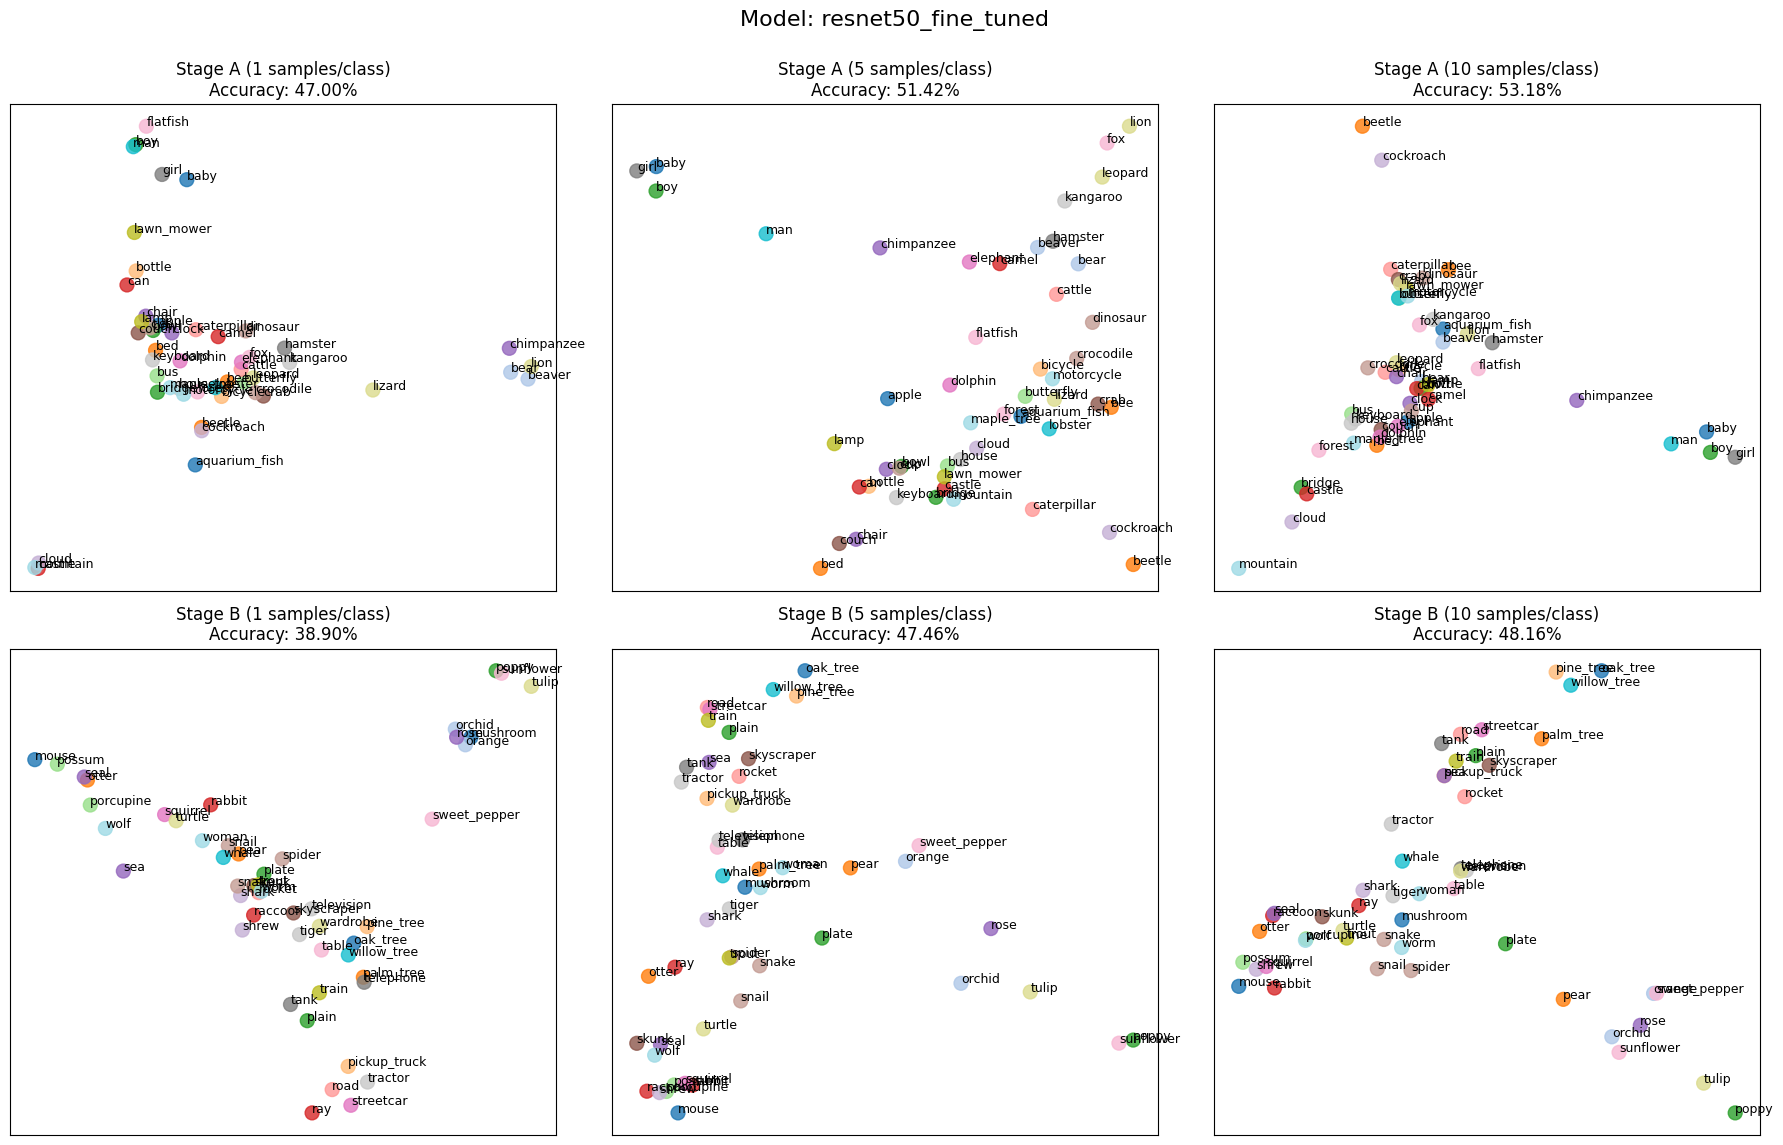

wide_resnet: 1 49.46
wide_resnet: 5 60.12
wide_resnet: 10 60.56


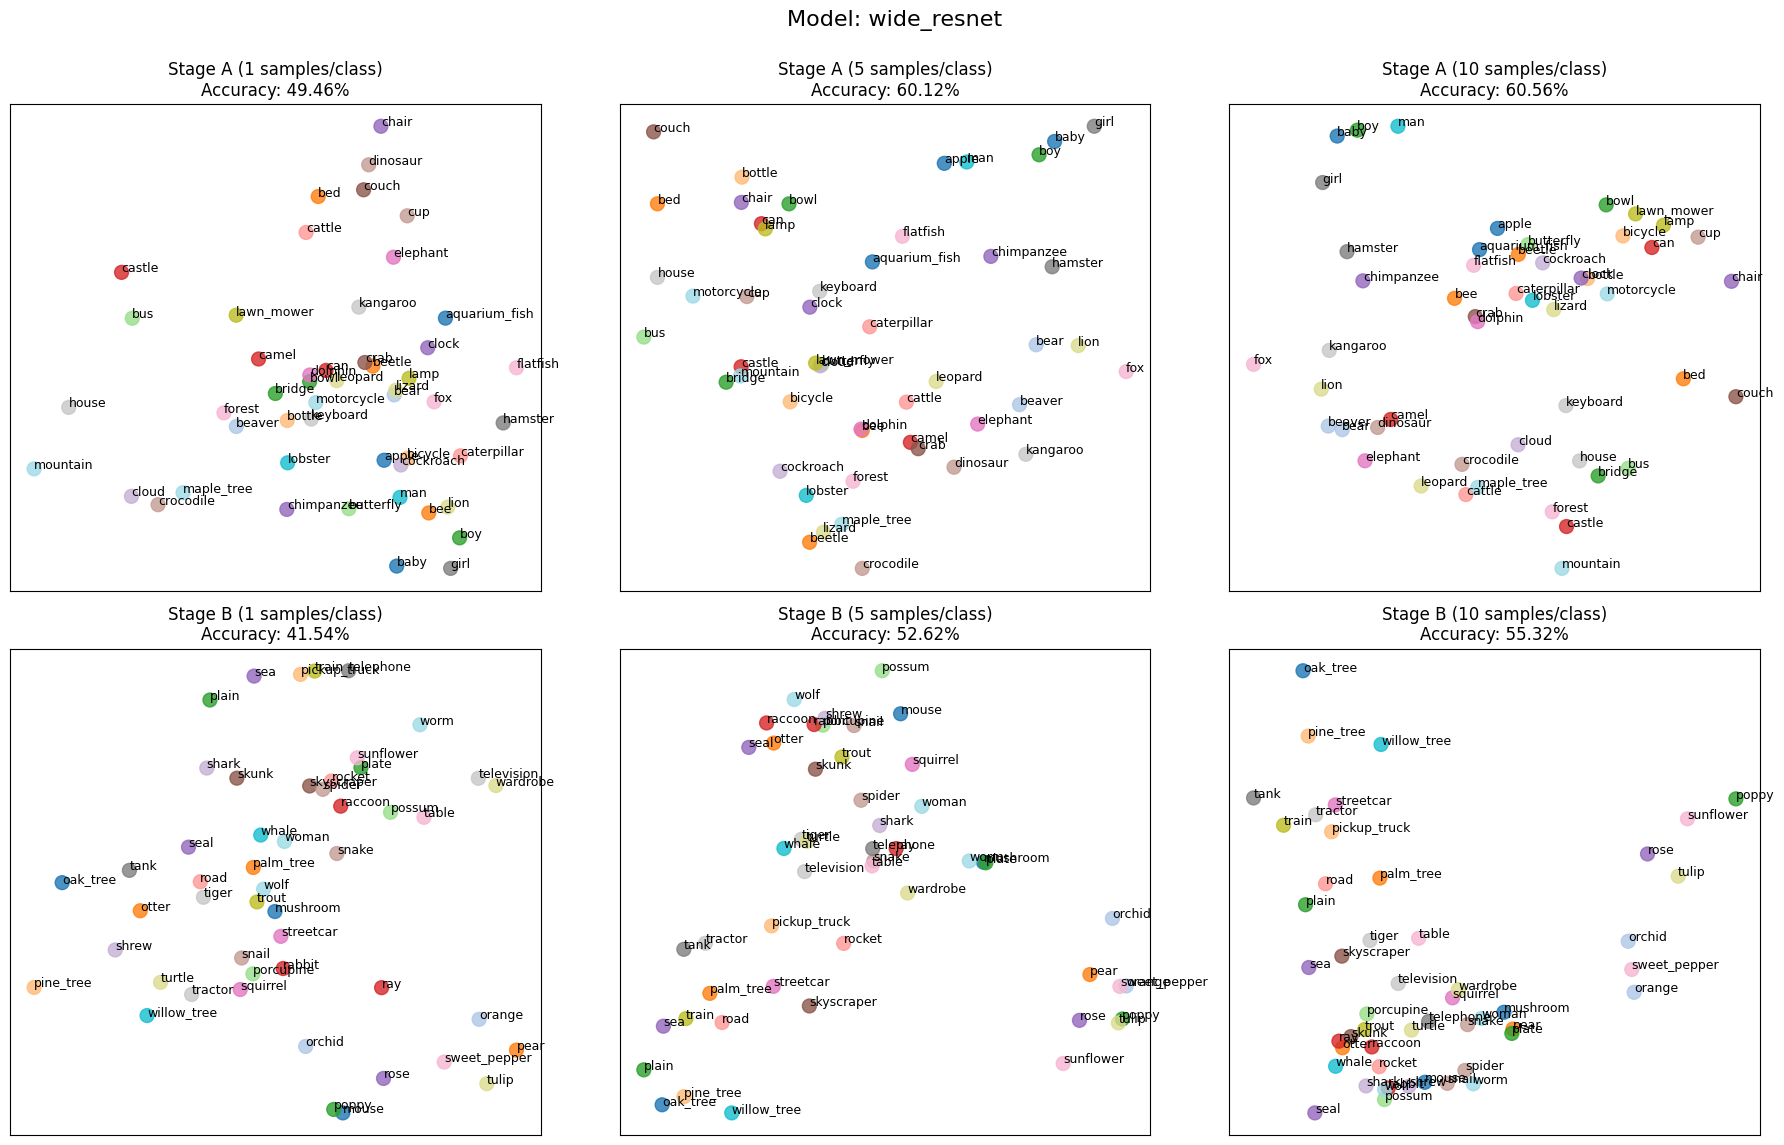

In [10]:
for model_name in models_names:
    pca_results_A = [None] * len(nums_samples)
    classes_list_A = [None] * len(nums_samples)
    accuracies_A = [None] * len(nums_samples)
    
    pca_results_B = [None] * len(nums_samples)
    classes_list_B = [None] * len(nums_samples)
    accuracies_B = [None] * len(nums_samples)

    # stage A (first, above):
    for idx, num_samples in enumerate(nums_samples):
        
        file_path = os.path.join(base_dir_A, f"{model_name}_{num_samples}_rep.npy")
        loaded_data = np.load(file_path, allow_pickle=True).item()
        
        classes = sorted(loaded_data.keys())
        features = np.array([loaded_data[k] for k in classes])
        
        pca = PCA(n_components=2)
        features_pca = pca.fit_transform(features)
        
        pca_results_A[idx] = features_pca
        classes_list_A[idx] = classes

        # extract test features from files (it would take too much time if they wasn't stored)
        test_features = os.path.join(os.path.join("..", "cache"), f"{model_name}_test_features.npy")
        test_labels = os.path.join(os.path.join("..", "cache"), f"{model_name}_test_labels.npy")

        accuracies_A[idx] = calculate_accuracy(models[model_name], loaded_data, test_loader, classes_A, test_features, test_labels, 1, 'euclidean')
        print(f"{model_name}: {num_samples} {accuracies_A[idx]}")


    # stage B:
    for idx, num_samples in enumerate(nums_samples):
        file_path = os.path.join(base_dir_B, f"{model_name}_{num_samples}.npy")        
        loaded_data = np.load(file_path, allow_pickle=True).item()
        
        classes = sorted(loaded_data.keys())
        features = np.array([loaded_data[k] for k in classes])
        
        pca = PCA(n_components=2)
        features_pca = pca.fit_transform(features)
        
        pca_results_B[idx] = features_pca
        classes_list_B[idx] = classes

        test_features = os.path.join(os.path.join("..", "cache"), f"{model_name}_test_features.npy")
        test_labels = os.path.join(os.path.join("..", "cache"), f"{model_name}_test_labels.npy")

        accuracies_B[idx] = calculate_accuracy(models[model_name], loaded_data, test_loader, classes_B, test_features, test_labels, 1, 'euclidean')

    plot_stages(pca_results_A, pca_results_B, classes_list_A, classes_list_B, accuracies_A, accuracies_B, model_name, class_dict)

# Cosine vs Euclidean (knn metrics comparison)

In [13]:
def plot_stage(ax, x, accuracies, stage_name, model_name, metrics):
    colors = ['blue', 'orange', 'green']
    
    for metric, color in zip(metrics, colors):
        ax.plot(x, accuracies[metric], label=metric.capitalize(), color=color)
    
    ax.set_xticks(x)
    ax.set_xticklabels(nums_samples)
    ax.set_xlabel('Number of Samples per Class')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title(f'{stage_name}: {model_name}')
    ax.legend()
    ax.grid(True)

def plot_accuracy_comparison(ax, nums_samples, accuracies_A, accuracies_B, model_name, metrics):
    x = np.arange(len(nums_samples))
    plot_stage(ax[0], x, accuracies_A, 'Stage A', model_name, metrics)
    plot_stage(ax[1], x, accuracies_B, 'Stage B', model_name, metrics)


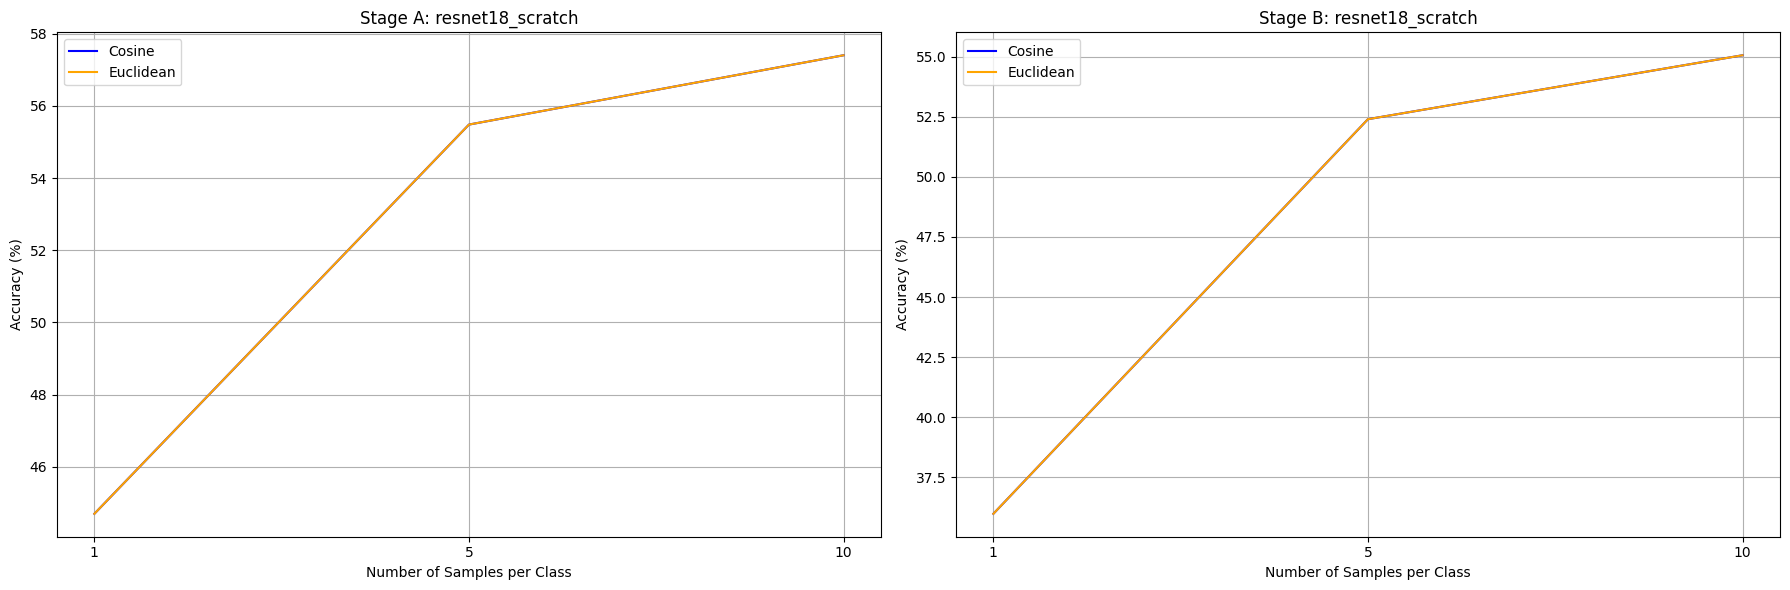

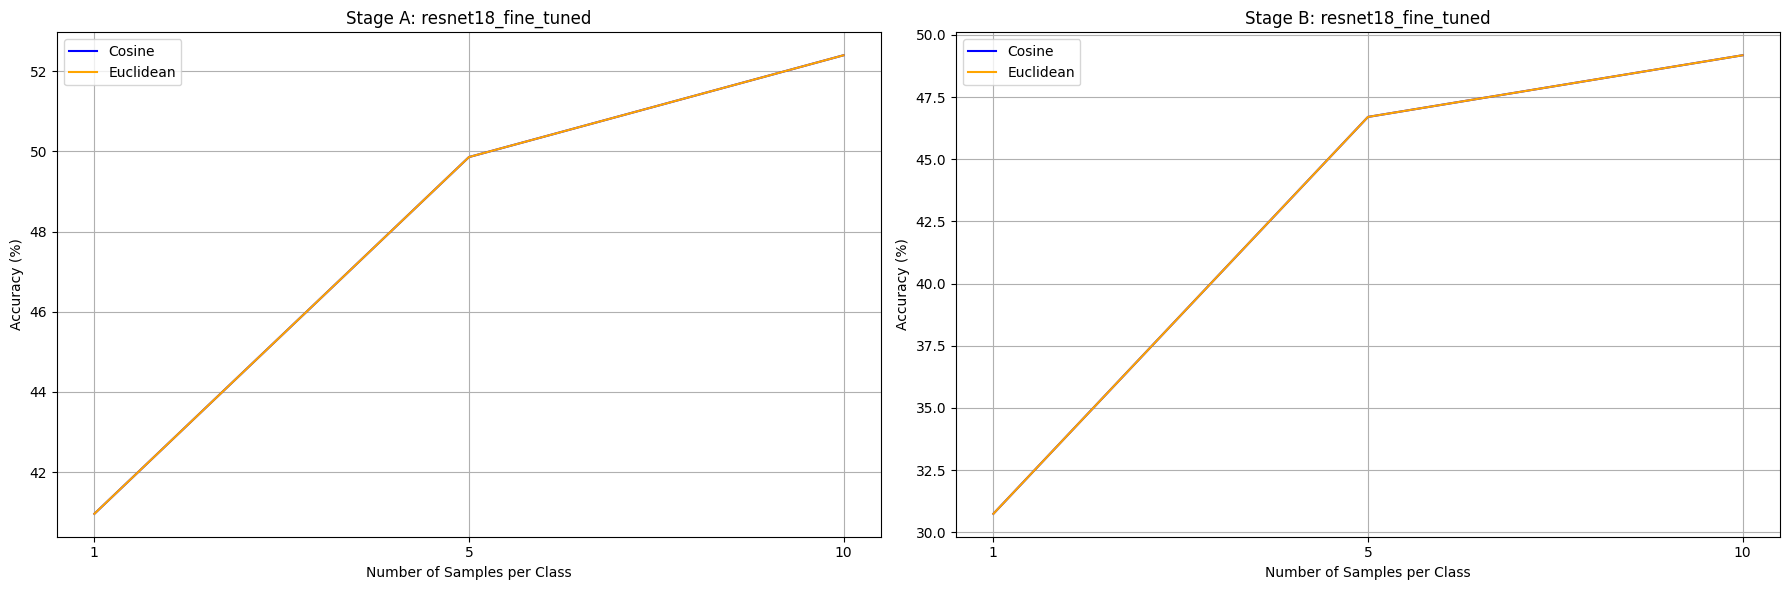

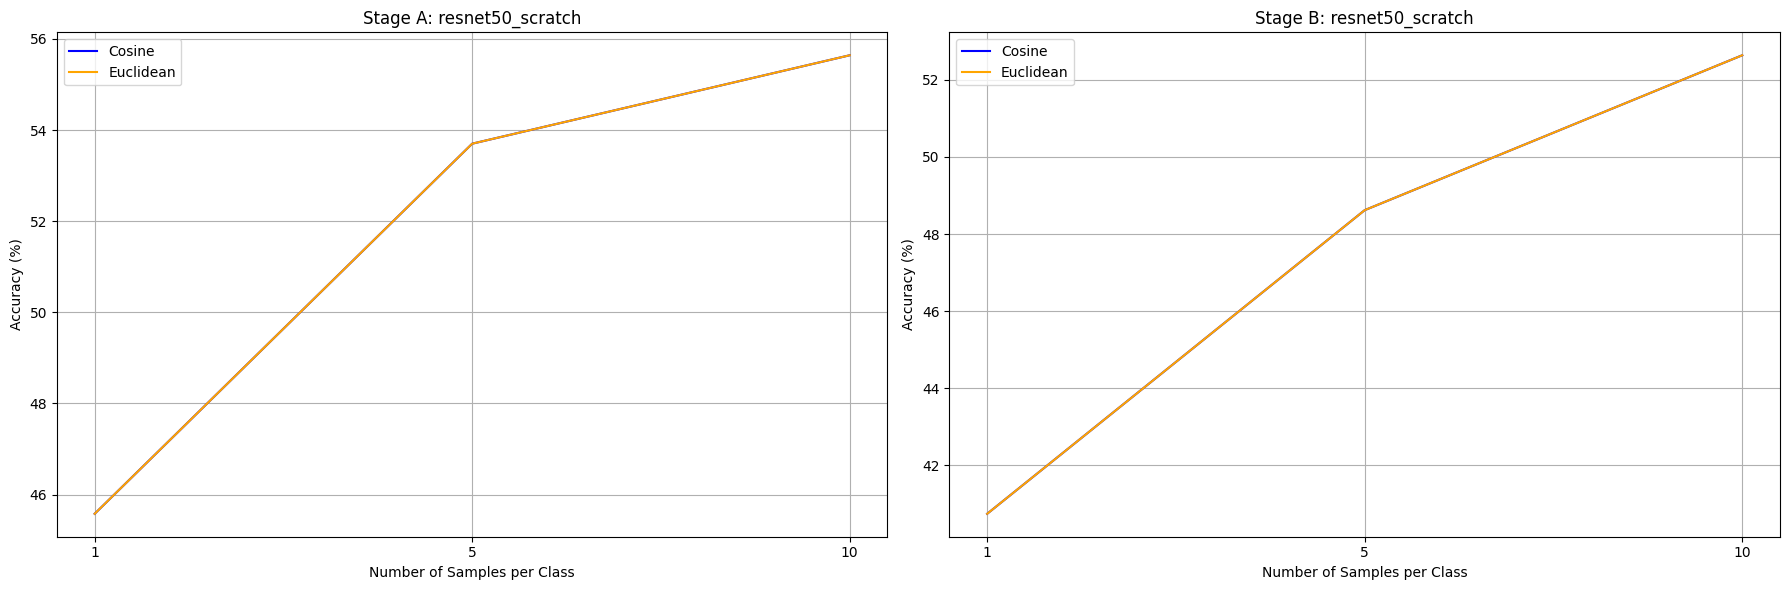

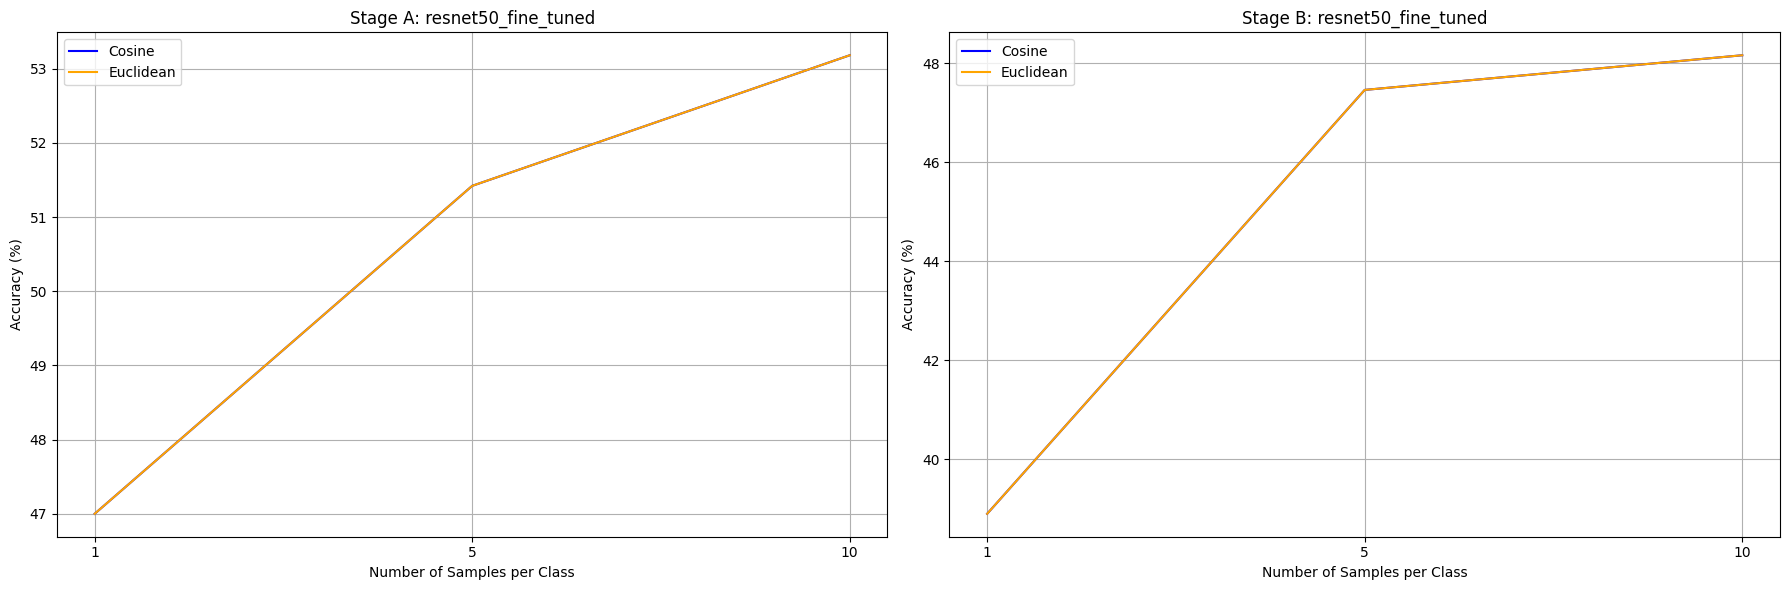

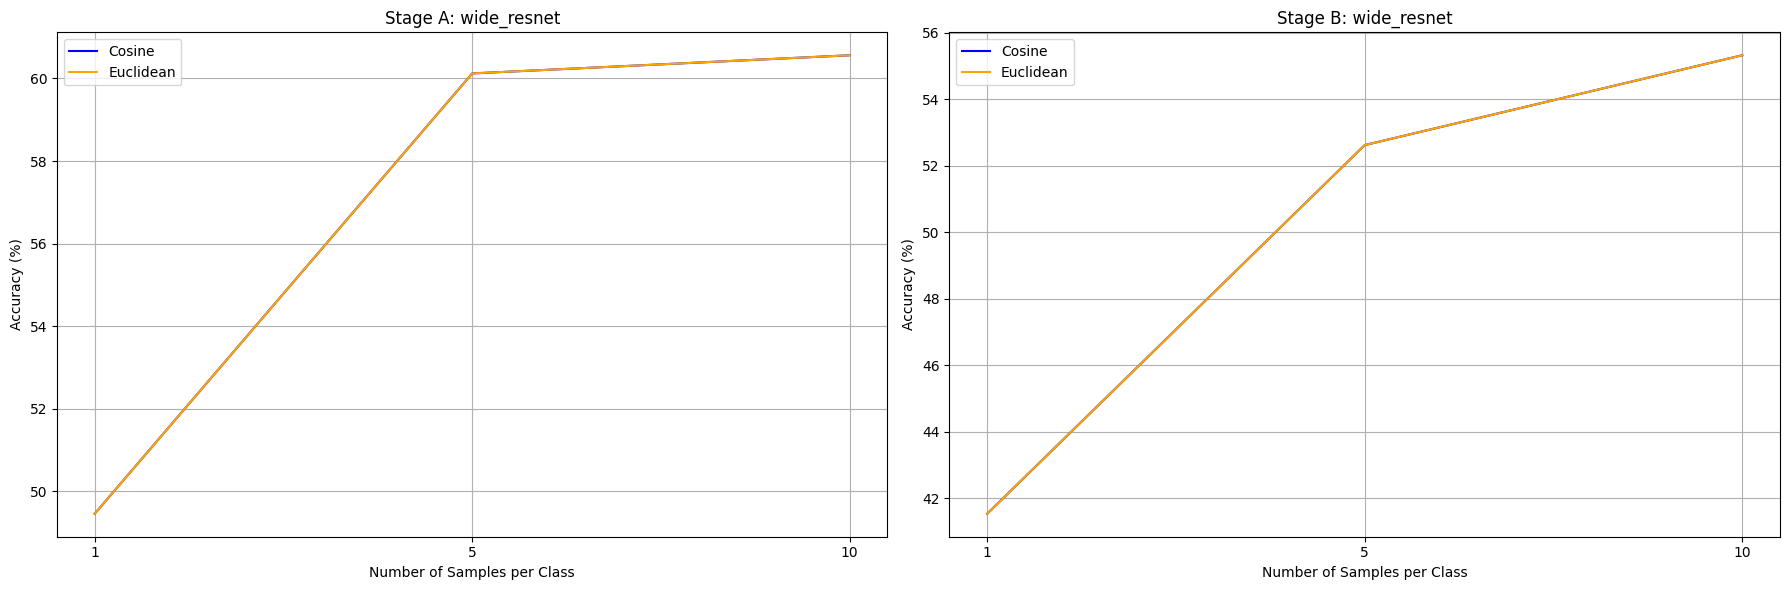

In [14]:
metrics = ['cosine', 'euclidean']

for model_name in models_names:
    accuracies_A = {metric: [] for metric in metrics}
    accuracies_B = {metric: [] for metric in metrics}

    for num_samples in nums_samples:
        rep_path_A = os.path.join(base_dir_A, f"{model_name}_{num_samples}_rep.npy")
        rep_A = np.load(rep_path_A, allow_pickle=True).item()

        test_features = os.path.join("..", "cache", f"{model_name}_test_features.npy")
        test_labels = os.path.join("..", "cache", f"{model_name}_test_labels.npy")

        for metric in metrics:
            norm = 'l2' if metric == 'euclidean' else ''  # Tylko dla 'euclideanl2'
            acc_A = calculate_accuracy(models[model_name], rep_A, test_loader, classes_A, test_features, test_labels, 1, metric=metric)
            accuracies_A[metric].append(acc_A)

        rep_path_B = os.path.join(base_dir_B, f"{model_name}_{num_samples}.npy")
        rep_B = np.load(rep_path_B, allow_pickle=True).item()

        for metric in metrics:
            norm = 'l2' if metric == 'euclideanl2' else ''  # Tylko dla 'euclideanl2'
            acc_B = calculate_accuracy(models[model_name], rep_B, test_loader, classes_B, test_features, test_labels, 1, metric=metric)
            accuracies_B[metric].append(acc_B)

    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    plot_accuracy_comparison(ax, nums_samples, accuracies_A, accuracies_B, model_name, metrics)
    plt.tight_layout()
    plt.show()


# Wnioski
Wraz ze zwiększaniem się liczby próbek, dokładność przewidywania przez KNN zwiększa się. Wraz ze wzrostem liczby sąsiadów, dokładność na wszystkich modelach, na wszystkich próbkach spada. Dokładności na etapie A, bazującym na 50 klasach, na których wykorzystane modele były trenowane, są większe niż na etapie B, bazującym na pozostałych 50 klasach "niewidocznych" podczas treningu. W dodatku w etapie B, różnice w dokładnościach dla różnych liczb próbek były bardziej widoczne - wzrastały drastyczniej wraz ze wzrostem liczby próbek.<br/><br/>
Cechy wyekstrachowane z modelu Wide Resnet były najlepiej klasyfikowane (największe dokładności) dzięki najszerszej warstwie przedklasyfikacyjnej, która pozwoliła na zachowanie największej liczby cech potrzebnych do rozróżnienia obiektów. Modele Resnet po fine-tuningu natomiast utrzymywały wyższe dokładności przy zwiększaniu liczby sąsiadów.<br/><br/>
Dla pojedynczych próbek, model ResNet50 poradził sobie lepiej niż ResNet18. Jednakże wraz ze wzrostem liczby próbek, głębokość sieci ResNet50 może prowadzić do przeuczenia na danych treningowych.<br/><br/>
Modele fine-tuned także lepiej sobie radziły na pojedynczych próbkach. Po ich zwiększeniu jednak można zauważyć spadek ich dokładności w porównaniu z modelami from-scratch. Jest to skutek tego, że modele "dostrojnone" za bardzo opierają się na pierwszych 50. klasach, co szkodzi w klasyfikacji nowych 50.